In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle

import numpy as np

import torch

from PIL import Image
import cv2

import matplotlib.pyplot as plt

import time

from comparemethods import plot_results, match_oanet, matcher, helpers, alignment, prepare_images
from poltilereconstructor.align_images.histology_image import HistologyImage

In [3]:
def _get_coordinates_superglue(self):
    """
    gets the minimum and maximum coordinates for the SuperGlue process.
    """
    coordinates_grid = self.folder.split('SEC')[2].split('-')[1].split('_')[0] if self.chicago else self.folder.split('SECTION-')[1].split('_')[0]
    coord_x = coordinates_grid[0]
    coord_y = int(coordinates_grid[1])
                
    # find global section boundaries
    arr_bool = np.sum(self.section, axis = 2) > 0
    x_min_global, x_max_global = np.min(np.where(arr_bool)[0]), np.max(np.where(arr_bool)[0])
    y_min_global, y_max_global = np.min(np.where(arr_bool)[1]), np.max(np.where(arr_bool)[1])

    max_idx, max_idy = 0, 0
    path_data_folder = '/'.join(self.folder.split('/')[:-1])
    path_dev_folder = path_data_folder.replace('data', 'dev')
    all_folders = os.listdir(path_data_folder) + os.listdir(path_dev_folder)
        
    for folder in all_folders:
        reg = re.findall(r'SEC\d-[A-Z]\d', folder) if self.chicago else re.findall(r'SECTION-[A-Z]\d', folder)
        if reg:
            max_id = reg[0].split('-')[1][0] if self.chicago else reg[0].split('SECTION-')[1][0]
            if max_id == 'X':
                pass
            else:
                max_idx = max(max_idx, string.ascii_lowercase.index(max_id.lower()) + 1)
                    
        reg = re.findall(r'SEC\d-' + coord_x + '\d', folder) if self.chicago else re.findall(r'SECTION-' + coord_x + '\d', folder)
        if reg:
            max_id = int(reg[0].split('-' + coord_x)[1])
            max_idy = max(max_idy, max_id)
          
    # calculate grid size and coordinates
    coord_x = max_idx - string.ascii_lowercase.index(coordinates_grid[0].lower())
    shape = (x_max_global - x_min_global, y_max_global - y_min_global)
    x_sz = int(shape[0] / max_idx)
    y_sz = int(shape[1] / max_idy)
    x_min, x_max = x_sz * (coord_x - 1), x_sz * coord_x
    y_min, y_max = y_sz * (coord_y - 1), y_sz * coord_y

    # adjust for proportional section sizes and buffer zones
    x_sz_prop = int(shape[0] / (max_idx * 0.9))
    y_sz_prop = int(shape[1] / (max_idy * 0.9))
    center_x = int((x_min + x_max) / 2) + x_min_global
    center_y = int((y_min + y_max) / 2) + y_min_global
    x_min = max(center_x - x_sz_prop - 150, 0)
    x_max = min(center_x + x_sz_prop + 150, shape[0])
    y_min = max(center_y - y_sz_prop - 150, 0)
    y_max = min(center_y + y_sz_prop + 150, shape[1])

    return x_min, x_max, y_min, y_max

In [2]:
type_alignment = 'polarimetry'

# SG better
# current_tiles = ['A1', 'A2', A4', 'C4']

# both the same
# current_tiles = ['B4', 'D2', 'D3']

# OANet better
# current_tiles = ['B1', 'B2', 'C1', 'C2', 'C3', 'C5', 'D4', 'D5']

# not the best for both
# current_tiles = ['B3', 'A5']


# current_tiles = ['A1', 'A2', 'A4', 'A5',
#                  'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', #'C5',
#                  'D2', 'D3', 'D4', #'D5'
#                 ]
current_tiles = ['A1']
batch_number = 1

parameters_dict = helpers.get_parameters(type_alignment, current_tiles)
images = prepare_images.prepare_imgs(parameters_dict, type_alignment)

# 1. Run the different methods and save the coordinates

### 1.1. SIFT + MNN

Processing time: 3.20 ± 0.00 s


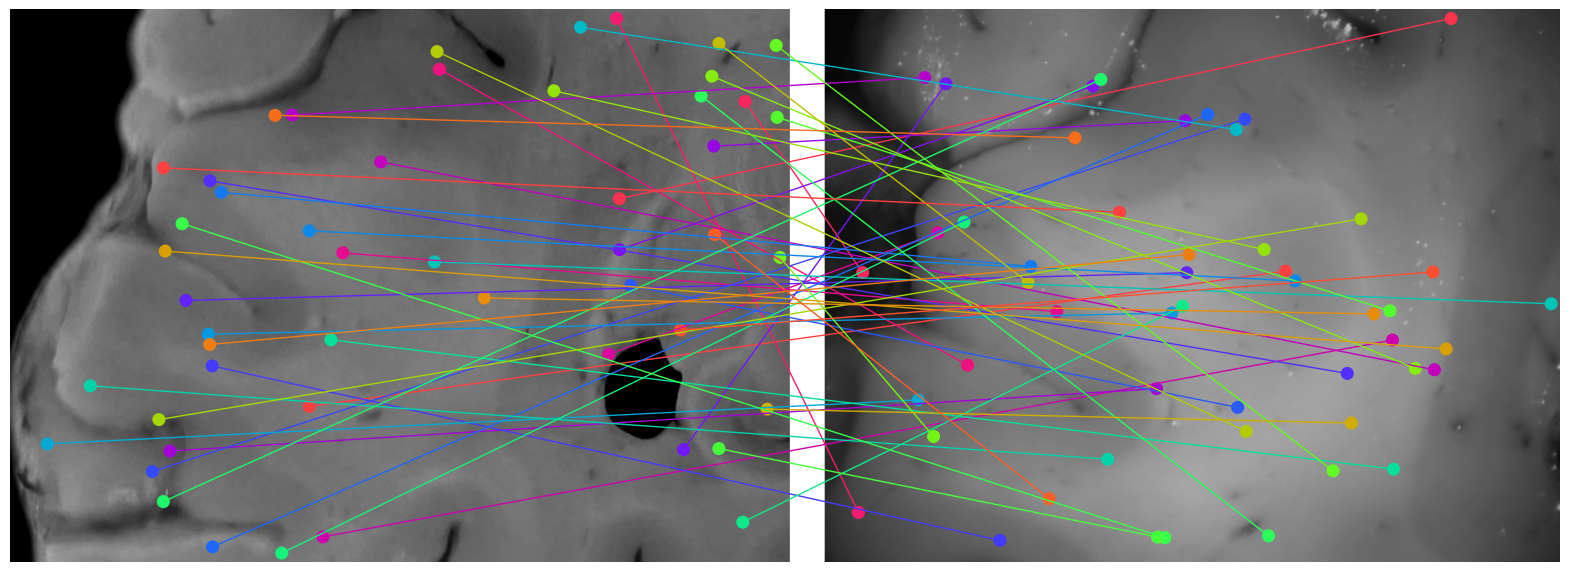

In [5]:
sift_mnn_pts = matcher.match('sift', 'mnn', batch_number, parameters_dict, images)

### 1.2. SiLK + MNN

Processing time: 13.51 ± 0.00 s


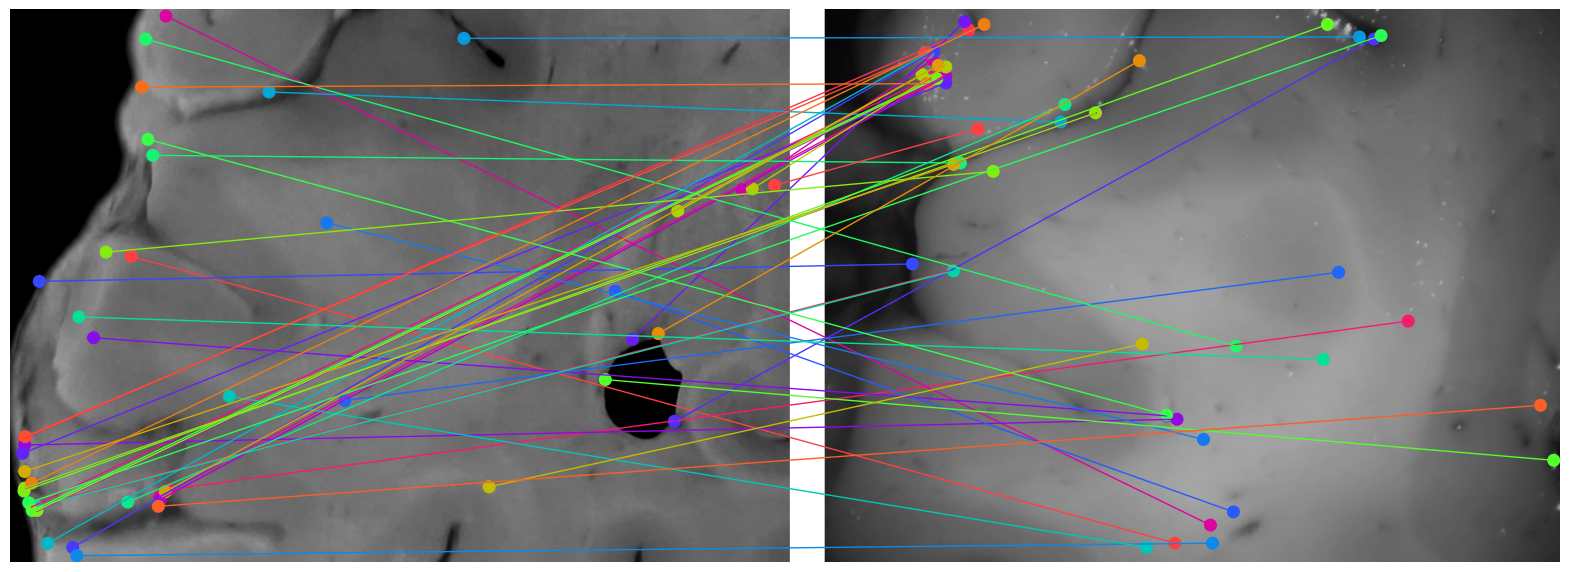

In [6]:
silk_mnn_pts = matcher.match('silk', 'mnn', batch_number, parameters_dict, images)

### 1.3. Superpoint + MNN

Processing time: 10.65 ± 0.00 s


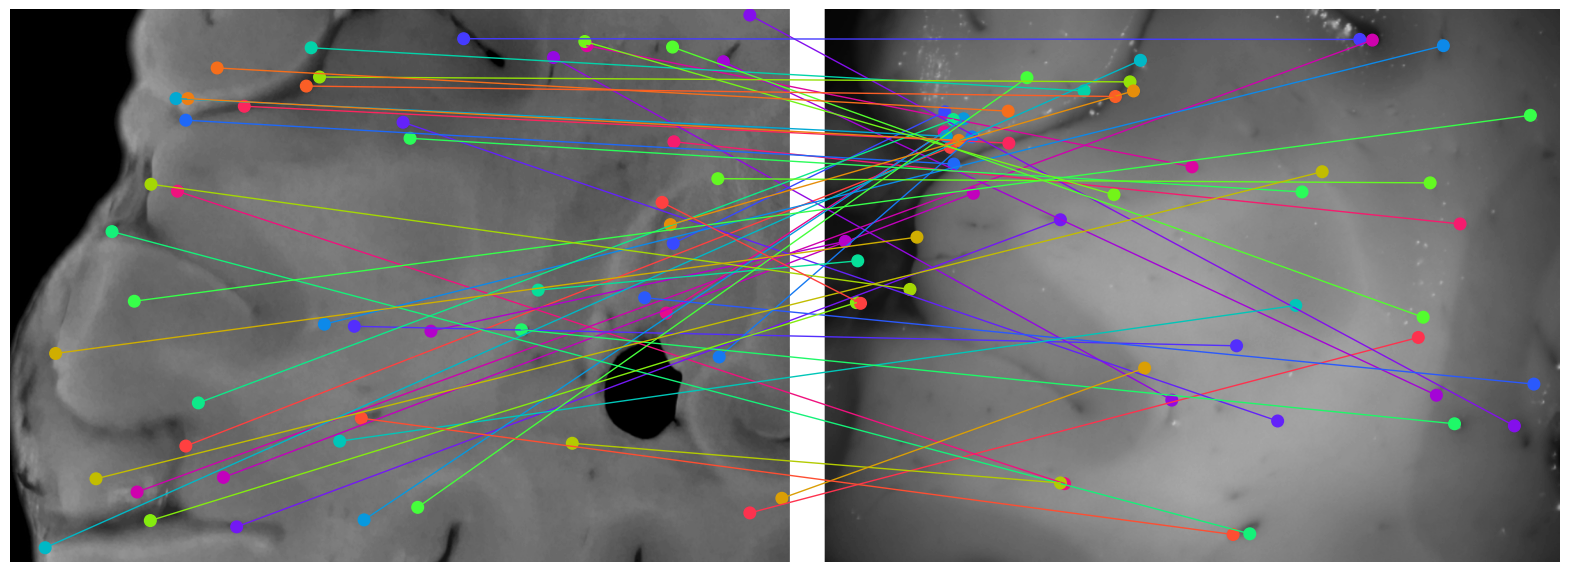

In [7]:
sp_mnn_pts = matcher.match('superpoint', 'mnn', batch_number, parameters_dict, images)

### 1.4. SIFT + OANet

Processing time: 4.92 ± 0.00 s


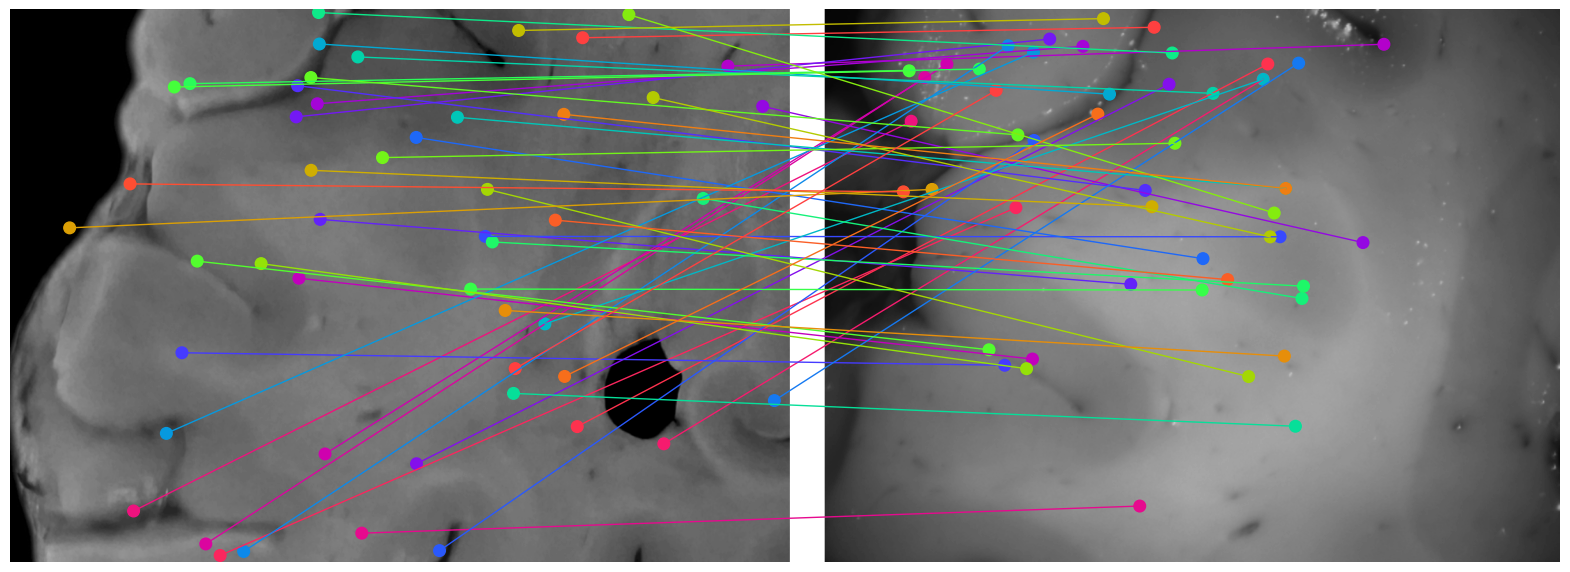

In [8]:
sift_oanet_pts = matcher.match('sift', 'oanet', batch_number, parameters_dict, images)

### 1.5. SiLK + OANet

Processing time: 18.95 ± 0.00 s


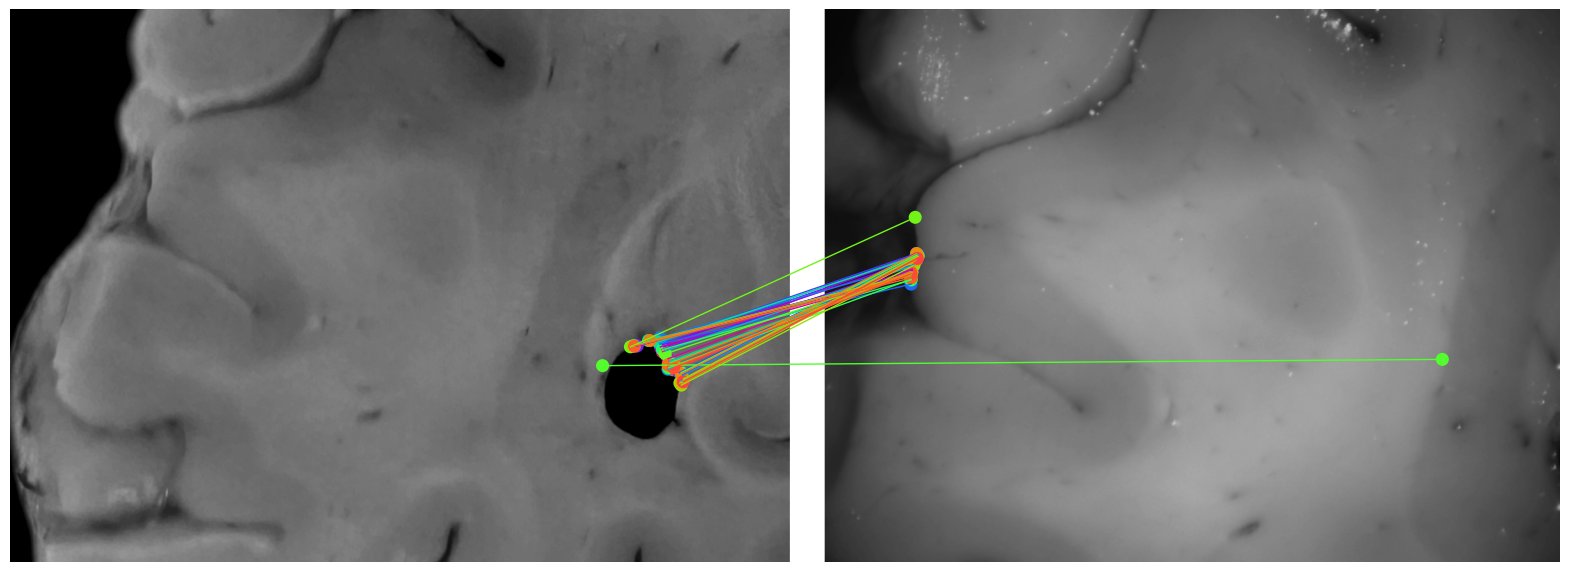

In [9]:
silk_oanet_pts = matcher.match('silk', 'oanet', batch_number, parameters_dict, images)

### 1.6. Superpoint + OANet

Processing time: 12.32 ± 0.00 s


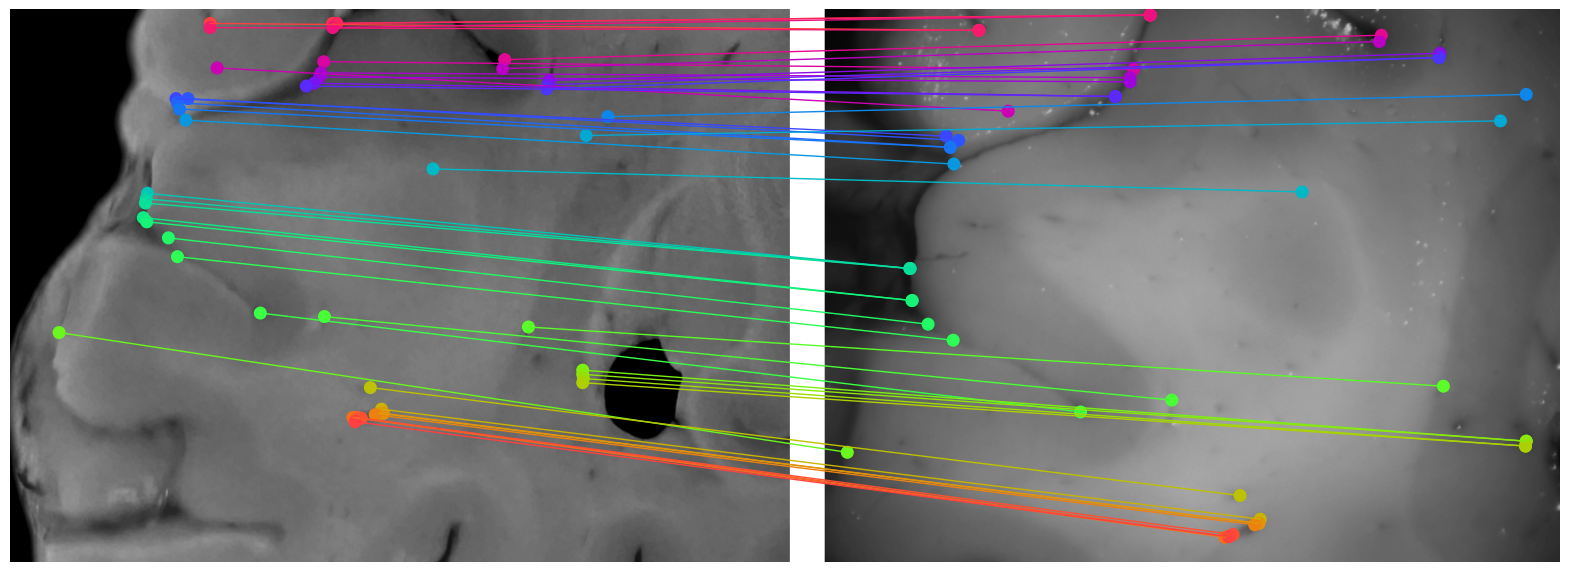

In [10]:
sp_oanet_pts = matcher.match('superpoint', 'oanet', batch_number, parameters_dict, images)

### 1.7. SP + SG

Processing time: 13.41 ± 0.00 s


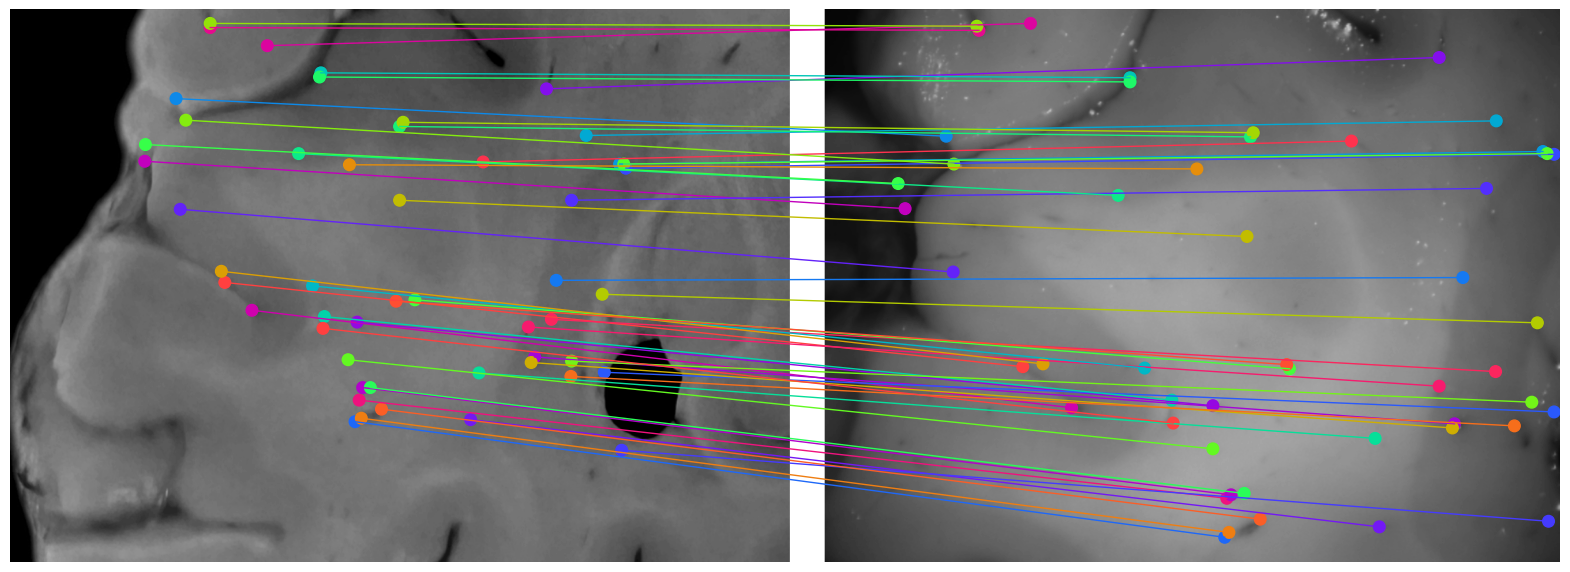

In [11]:
sp_sg_pts = matcher.match('superpoint', 'superglue', batch_number, parameters_dict, images)

# 2. Align the images using bUnwarpJ and the previously obtained coordinates

In [13]:
combinations = (('sift', 'mnn'), ('silk', 'mnn'), ('superpoint', 'mnn'), ('sift', 'oanet'), ('silk', 'oanet'), ('superpoint', 'oanet'), ('superpoint', 'superglue'))

In [56]:
if type_alignment == 'polarimetry':
    coordinates = alignment.load_manual_coordinates(parameters_dict)
    alignment.align_images(parameters_dict, ['gt'], coordinates)
    
else:
    pass

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:03<00:00, 63.64s/it]


In [14]:
rmses, metrics = alignment.find_rmse(parameters_dict, images, combinations, type_alignment)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


In [15]:
rmses

{'B1': {('sift', 'mnn'): 512.8793264388536,
  ('silk', 'mnn'): 519.9598028038243,
  ('superpoint', 'mnn'): 449.9990828914817,
  ('sift', 'oanet'): 347.8732527803769,
  ('silk', 'oanet'): 952.1941512918391,
  ('superpoint', 'oanet'): 11.398830349353101,
  ('superpoint', 'superglue'): 21.74915265075035}}

In [14]:
all_distances = {}
for combination in combinations:
    distances = []
    
    for key, val in tqdm(parameters_dict.items(), total = len(parameters_dict)):
        path_distances = val['path_distances']
        try:
            with open(f'{path_distances}/{combination[0]}_{combination[1]}.txt') as file:
                distance_tile = file.readlines()
            for dist in distance_tile:
                distances.append(float(dist.replace('\n', '')))
        except:
            pass
    all_distances[combination] = distances

NameError: name 'tqdm' is not defined

In [136]:
from tqdm import tqdm

rmses = {}
metrics = {}
for key, distance in tqdm(all_distances.items(), total = len(all_distances)):
    if type_alignment == 'polarimetry':
        threshold = 30
    else:
        threshold = 10
        
    rmses[key] = alignment.bootstrap_parameters(distance, type_alignment, parameter = 'rmse',
                                                num_samples = 1000)
    metrics[key] = alignment.bootstrap_parameters(distance, type_alignment, parameter = 'precision', 
                                                  threshold = threshold, num_samples = 1000)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:19<00:00,  2.84s/it]


In [137]:
rmses

{('sift', 'mnn'): (501.41133442909774,
  2.956566454092524,
  17.047985370589323,
  0.10052325943914582),
 ('silk', 'mnn'): (503.3985437125956,
  6.0715902077928945,
  17.11555048622825,
  0.20643406706495843),
 ('superpoint', 'mnn'): (417.32230675692296,
  11.065328453679285,
  14.188958429735381,
  0.3762211674250957),
 ('sift', 'oanet'): (354.21063100711393,
  5.718919445246797,
  12.043161454241874,
  0.1944432611383911),
 ('silk', 'oanet'): (179.5335728947093,
  4.7087832948233626,
  6.104141478420116,
  0.16009863202399433),
 ('superpoint', 'oanet'): (21.148770965024944,
  1.6800765002937794,
  0.7190582128108481,
  0.057122601009988505),
 ('superpoint', 'superglue'): (16.860052102107584,
  0.7370447350015557,
  0.5732417714716579,
  0.025059520990052896)}

In [138]:
metrics

{('sift', 'mnn'): (1.4395534437422153, 0.1545416801217882),
 ('silk', 'mnn'): (7.20583817486184, 0.5809834207170184),
 ('superpoint', 'mnn'): (27.036359867330017, 1.8449419568822538),
 ('sift', 'oanet'): (7.214254975793438, 0.5918840774610002),
 ('silk', 'oanet'): (44.627338213082375, 1.0228593005693036),
 ('superpoint', 'oanet'): (91.06005917159762, 1.553254437869822),
 ('superpoint', 'superglue'): (93.32494529540482, 0.9846827133479175)}